<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw2/p3_DANN_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.transforms as tr
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Download zip file

In [ ]:
!pip install gsutil
!gsutil cp /content/drive/MyDrive/NTU_DLCV/Hw2/hw2_data.zip /content/hw2_data.zip

In [ ]:
!unzip /content/hw2_data.zip

#### Get cuda from GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Construct Dataset

In [ ]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, label_path: str, join_path: str, transform) -> None:
        self.transform = transform
        self.img_paths = []
        self.img_labels = []

        label_csv = pd.read_csv(label_path).values.tolist()

        for row in label_csv:
            self.img_paths.append(os.path.join(join_path, row[0]))
            self.img_labels.append(row[1])
        assert len(self.img_paths) == len(self.img_labels)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx) -> (torch.Tensor, int):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB') # (28, 28, 3)
        img = self.transform(img)

        label = self.img_labels[idx]
        return img, label

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

source_val_ds = MnistDataset(
    label_path='/content/hw2_data/digits/mnistm/train.csv',
    join_path='/content/hw2_data/digits/mnistm/data',
    transform=tr.Compose([
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
    ])
)

svhn_val_ds = MnistDataset(
    label_path='/content/hw2_data/digits/svhn/val.csv',
    join_path='/content/hw2_data/digits/svhn/data',
    transform=tr.Compose([
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
    ])
)

usps_val_ds = MnistDataset(
    label_path='/content/hw2_data/digits/usps/val.csv',
    join_path='/content/hw2_data/digits/usps/data',
    transform=tr.Compose([
        tr.ToTensor(),
        tr.Normalize(mean=mean, std=std),
    ])
)

In [ ]:
BATCH_SIZE = 512

source_val_loader = DataLoader(source_val_ds, BATCH_SIZE, shuffle=False, num_workers=4)
svhn_val_loader = DataLoader(svhn_val_ds, BATCH_SIZE, shuffle=False, num_workers=4)
usps_val_loader = DataLoader(usps_val_ds, BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Construct Feature Extractor

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self) -> None:
        super(FeatureExtractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(3, 64, 5), # (64, 24, 24)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # (64, 11, 11)

            nn.Conv2d(64, 64, 5), # (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # (64, 3, 3)

            nn.Conv2d(64, 128, 3), # (128, 1, 1)
        )

    def forward(self, x):
        features = self.extractor(x)
        features = features.view(-1, 128)
        return features

#### SVHN plot

In [ ]:
feature_extractor = FeatureExtractor()
feature_extractor.to(device)

feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/NTU_DLCV/Hw2/p3_ckpt_SVHN/304feature_extractor.pth', map_location=device))

features_array = []
label_array = []
domain_array = []

with torch.no_grad():
    for x, y in source_val_loader:
        x = x.to(device)

        features = feature_extractor(x)
        features_array.append(features.cpu().numpy())
        label_array.append(y.cpu().numpy())
        domain_array.append(np.zeros((len(x),), dtype=np.int16))

    for x, y in svhn_val_loader:
        x = x.to(device)

        features = feature_extractor(x)
        features_array.append(features.cpu().numpy())
        label_array.append(y.cpu().numpy())
        domain_array.append(np.ones((len(x),), dtype=np.int16))

In [ ]:
features_array = np.concatenate(features_array, axis=0)
label_array = np.concatenate(label_array, axis=0)
domain_array = np.concatenate(domain_array, axis=0)



tsne_features = TSNE(
    n_components=2,
    n_jobs=-1
).fit_transform(features_array)

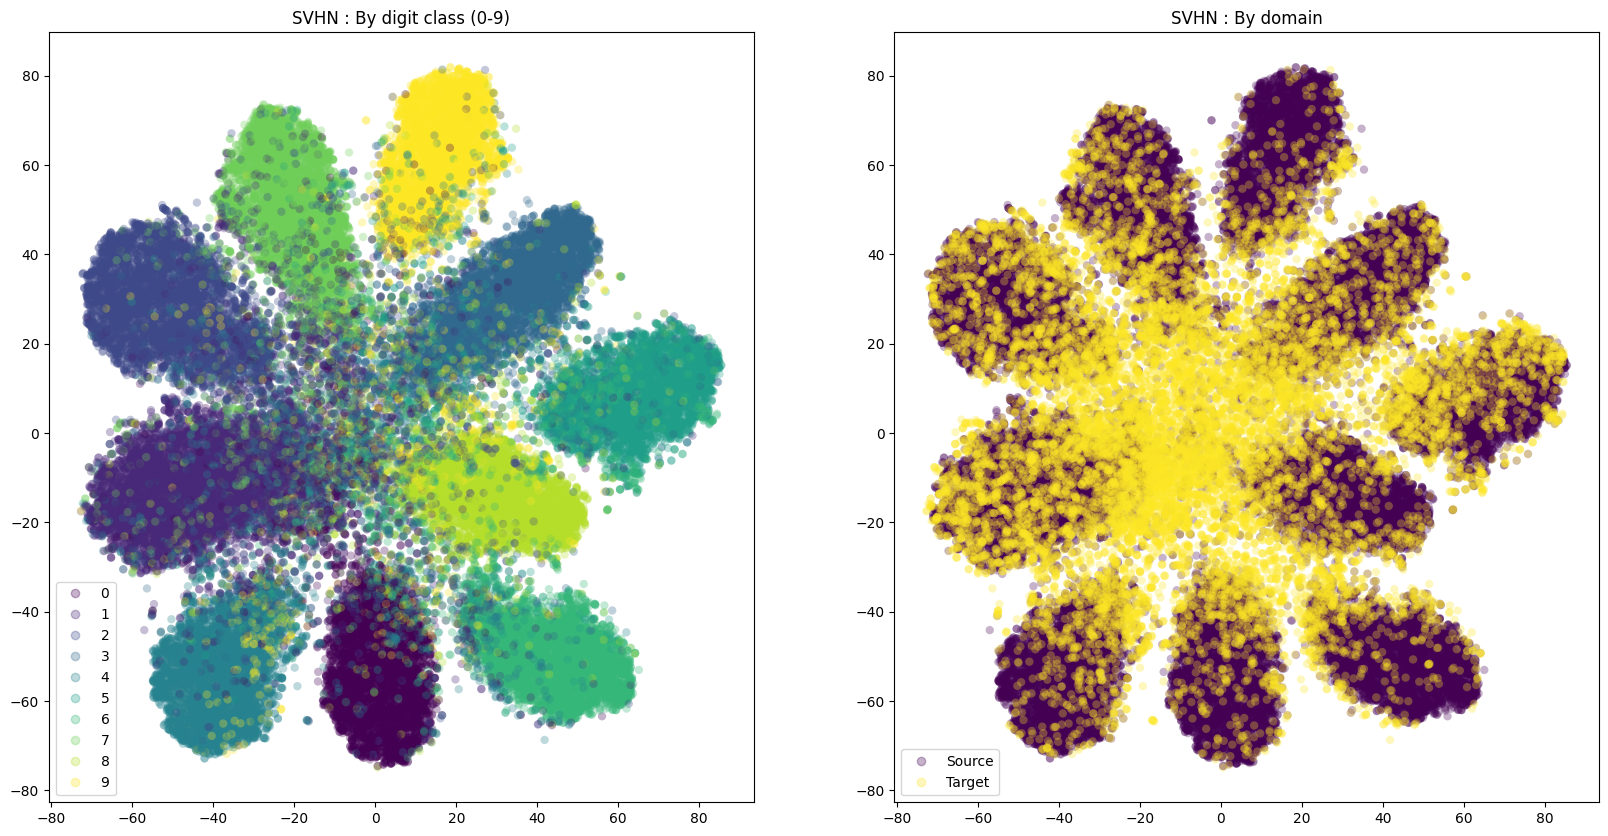

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

scatter_plot = ax[0].scatter(
    tsne_features[..., 0],
    tsne_features[..., 1],
    c=label_array,
    alpha=0.3,
    edgecolors='none',
)
ax[0].legend(
    *scatter_plot.legend_elements(),
    loc="lower left",
    # title='Digits',
)
ax[0].set_title("SVHN : By digit class (0-9)")

scatter_plot = ax[1].scatter(
    tsne_features[..., 0],
    tsne_features[..., 1],
    c=domain_array,
    alpha=0.3,
    edgecolors='none',
)
ax[1].legend(
    handles=scatter_plot.legend_elements()[0],
    loc="lower left",
    labels=['Source', 'Target'],
    # title='Domains',
)
ax[1].set_title("SVHN : By domain")

plt.show()
fig.savefig('/content/drive/MyDrive/NTU_DLCV/Hw2/p3_plot/SVHN.png')

#### USPS plot

In [ ]:
feature_extractor = FeatureExtractor()
feature_extractor.to(device)

feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/NTU_DLCV/Hw2/p3_ckpt_USPS/323feature_extractor.pth', map_location=device))

features_array = []
label_array = []
domain_array = []

with torch.no_grad():
    for x, y in source_val_loader:
        x = x.to(device)

        features = feature_extractor(x)
        features_array.append(features.cpu().numpy())
        label_array.append(y.cpu().numpy())
        domain_array.append(np.zeros((len(x),), dtype=np.int16))

    for x, y in usps_val_loader:
        x = x.to(device)

        features = feature_extractor(x)
        features_array.append(features.cpu().numpy())
        label_array.append(y.cpu().numpy())
        domain_array.append(np.ones((len(x),), dtype=np.int16))

In [ ]:
features_array = np.concatenate(features_array, axis=0)
label_array = np.concatenate(label_array, axis=0)
domain_array = np.concatenate(domain_array, axis=0)



tsne_features = TSNE(
    n_components=2,
    n_jobs=-1,
).fit_transform(features_array)

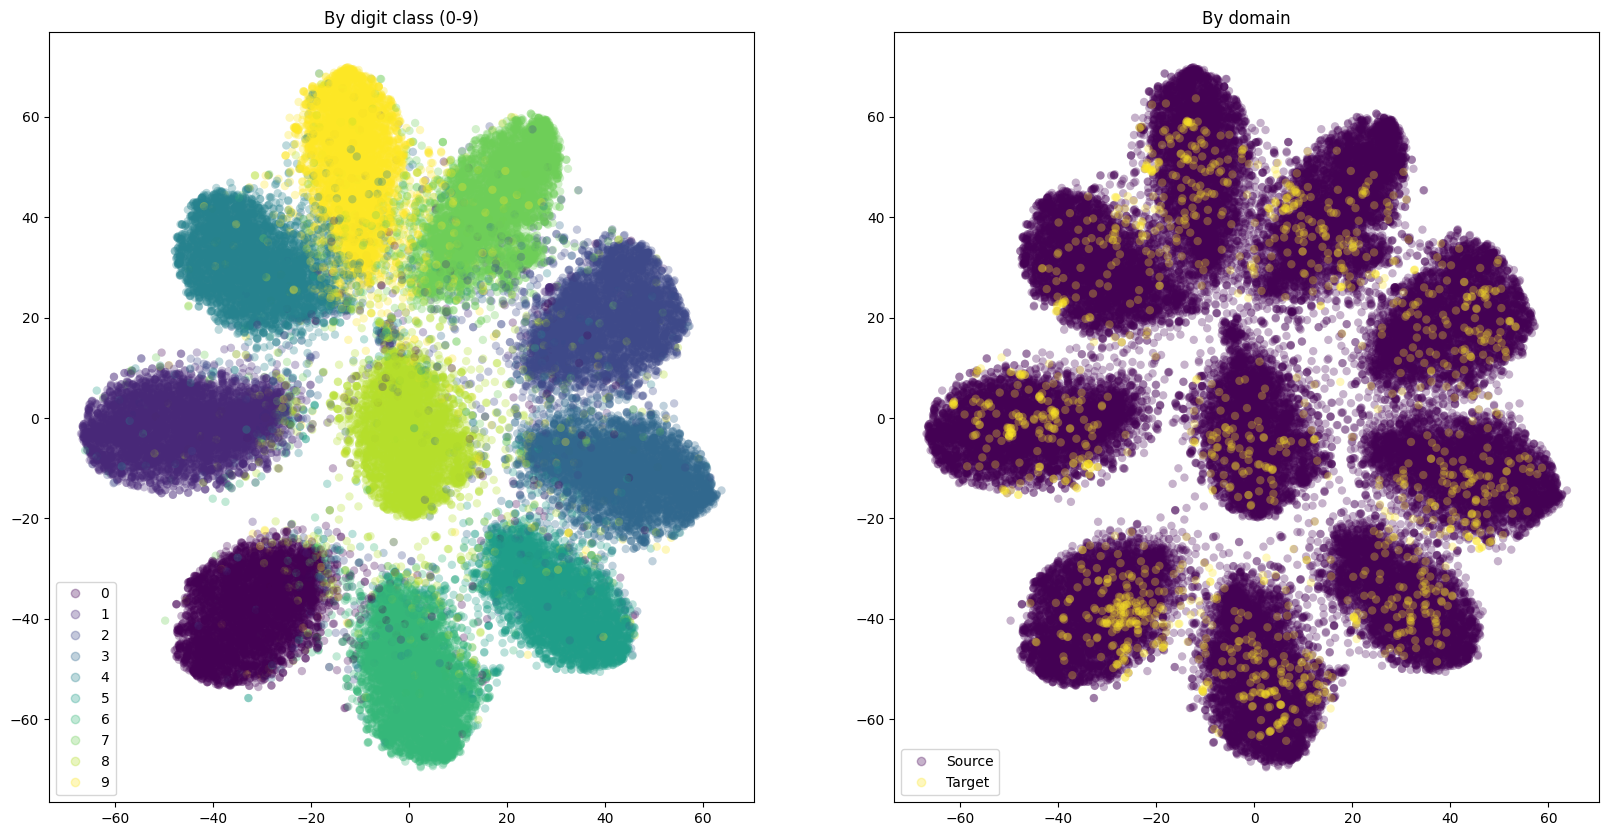

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

scatter_plot = ax[0].scatter(
    tsne_features[..., 0],
    tsne_features[..., 1],
    c=label_array,
    alpha=0.3,
    edgecolors='none',
)
ax[0].legend(
    *scatter_plot.legend_elements(),
    loc="lower left",
    # title='Digits',
)
ax[0].set_title("By digit class (0-9)")

scatter_plot = ax[1].scatter(
    tsne_features[..., 0],
    tsne_features[..., 1],
    c=domain_array,
    alpha=0.3,
    edgecolors='none',
)
ax[1].legend(
    handles=scatter_plot.legend_elements()[0],
    loc="lower left",
    labels=['Source', 'Target'],
    # title='Domains',
)
ax[1].set_title("By domain")

plt.show()
fig.savefig('/content/drive/MyDrive/NTU_DLCV/Hw2/p3_plot/USPS.png')